# **CIS 545 Homework 5: Deep Learning with PyTorch**

### **Due Date: April 14th, 2021 at 10 PM ET**

Welcome to CIS 545 Homework 5! 

In this homework, we will learn more about the "new electricity" - Deep Learning (we didn't coin this term, Andrew Ng did)! There are many cool frameworks for building deep learning models:  PyTorch, Tensorflow, Theano, MxNet. Since you will be working with Big Data in this course, you need a framework that scales well. Almost all of these have multi-GPU support built in; PyTorch provides an easy abstractions to do this and works well with AWS as well as Colab. In this assignment, we will be building neural networks in PyTorch to solve an interesting problem.

Deep learning or neural network architectures have been used to solve a multitude of problems in various different fields like vision, natural language processing, and radiology. So let's take a "deep" dive into them!

![](http://4.bp.blogspot.com/-sLgBLS3bJO8/U__Kx6PnkRI/AAAAAAAAAWM/Gz3cL5jiwTo/s320/godeeper.jpg)





## Why deep learning? 


*   It's coooool
*   Everyone is talking about is these days, People like Siraj Raval can teach it in 5 mins (Check out his youtube channel for some comedy)
*    Deep learning unlocks the treasure trove of unstructured big data for those with the imagination to use it
*   Deep learning models have great representational power and are 'universal approximators'


### Deep Learning Applications:


Deep learning has been significantly improved voice command systems (such as Siri and Alexa), as well as healthcare and image identification.

Deep learning has applications across numerous industries, which is why experts think that this technology is the future of almost everything. There are truly deep learning technologies such as Google’s very human-like talking AI, a new theory that cracks the 'black box' of deep learning, and various budding ideas like this one about why human forgetting might be the key to AI. Here are some cool applications of deep learning - 

Here's a neural network detecting anomalies in Chest Xrays :




![alt text](https://imgur.com/HKPzrzP.jpg)

Most humans can't tell that this is a case of Pleural Effusion {sounds like medical jargon to engineers like us} but this Neural Network model can detect it very well!

Mask RCNNs in action for detecting objects on the road aiding a self driving vehicle's driving: 
![alt text](https://miro.medium.com/max/3864/1*O4wsvh0CHWjP6IrK9HI_Zg.png)

Pretty cool, right? We will be appling CNNs to solve a cool image classification problem.


# Setup Skeleton



## Penn Grader Setup
Make sure to initialize the grader with your 8 digit Penn ID.

In [1]:
%%capture
!pip3 install penngrader

from penngrader.grader import *

VERY IMPORTANT : Enter your **8 digit Penn ID** in the student id field below

PLEASE NOTE: There are some questions, for example making plots, that do not have test cases. All questions without an autograder attached will be manually graded. 

In [2]:
# PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. 
# IF NOT, THE AUTOGRADER WON'T KNOW WHO TO ASSIGN POINTS TO IN OUR BACKEND
STUDENT_ID =  39977067  # YOUR PENN-ID GOES HERE AS AN INTEGER

In [3]:
grader = PennGrader(homework_id = 'CIS545_Spring_2021_HW5', student_id = STUDENT_ID)

PennGrader initialized with Student ID: 39977067

Make sure this correct or we will not be able to store your grade


## PyTorch Installation

First, verify that you see a cuda gpu listed here if you want to get a faster training speed...

In [4]:
!pip install torch torchvision

In [5]:
import shutil
import torch
import torchvision
import torch.nn as nn
from torchsummary import summary
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
print(torch.__version__)
print(device)

1.8.1+cu101
cuda:0


# Section 1 : Task Definition - Indoor Scene Recognition
## 1.1 Lots of Data

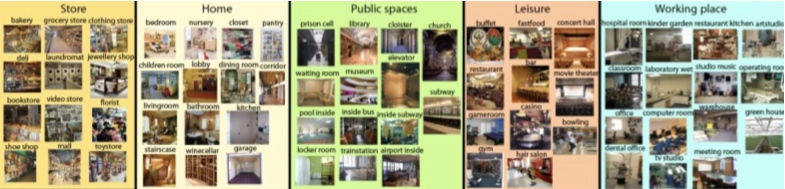

The datset we use is used for the indoor scene recognition problem. Indoor scene recognition is a challenging open problem in high level vision. Most scene recognition models that work well for outdoor scenes perform poorly in the indoor domain. The main difficulty is that while some indoor scenes (e.g. corridors) can be well characterized by global spatial properties, others (e.g., bookstores) are better characterized by the objects they contain. More generally, to address the indoor scenes recognition problem we need a model that can exploit local and global discriminative information.
 
The dataset contains 67 Indoor categories. The number of images varies across categories, but there are at least 100 images per category. All images are in jpg format. 

## Download the dataset
Run the cell below to mount your Google Drive folder to colab.

In [7]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)

# create folder to write data to
CIS545_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS545_2021')
HOMEWORK_FOLDER=os.path.join(CIS545_FOLDER, 'HW5')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Download the data into your google drive. 

You need to run this cell only once!  We've included a check so it won't redundantly download the data.

In [8]:
from google_drive_downloader import GoogleDriveDownloader as gdd

file_path = os.path.join(HOMEWORK_FOLDER, "data.zip")
if not os.path.isfile(file_path):
    gdd.download_file_from_google_drive(file_id='1A-dYo1ba1mjTrnH6xjzYrg_fO_GxHjvN',
                                      dest_path=file_path)

## 1.1.1 Filter out corrupt and nonexistent images (5 points)

There are a lot of images in the dataset that aren't valid JPEG images. We need to filter out the invalid images! Complete the check_corrupt function which takes in a filename and returns a boolean that is true if the file is corrupt and false if it is valid. Hint: the PIL library would be useful for this verification!




In [11]:
#unzip "/content/gdrive/My Drive/CIS545_2021/HW5/data.zip"

In [9]:
from PIL import Image

# TODO: Implement this function to filter out invalid images
def check_corrupt(filename):
  try:
    im=Image.open(filename)
    if im.mode != 'P' and im.format =="JPEG":
      return False
    else:
      return True
  except IOError:
    return True

In [10]:
# Check all images in the train file for validity and write the valid ones to train_path
shutil.unpack_archive(file_path)

base_path = '/content/indoorCVPR_09/Images'
train_path = os.path.join(base_path, 'train/')
test_path = os.path.join(base_path,'test/')
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

correct_file_count_train = 0
train_file = open("/content/TrainImages.txt", "r") 
for file in train_file:
    image_path = os.path.join(base_path, file.rstrip('\n'))
    dest_folder = os.path.join(train_path, file.split('/')[0])
    os.makedirs(dest_folder, exist_ok=True)
    dest_path = os.path.join(train_path, file.rstrip('\n'))
    if os.path.getsize(image_path) == 0 or check_corrupt(image_path):
        continue
    correct_file_count_train += 1
    dest = shutil.move(image_path, dest_path)  

correct_file_count_test = 0
test_file = open("/content/TestImages.txt", "r") 
for file in test_file:
    image_path = os.path.join(base_path,file.rstrip('\n'))
    dest_folder = os.path.join(test_path, file.split('/')[0])
    os.makedirs(dest_folder, exist_ok=True)
    dest_path = os.path.join(test_path,file.rstrip('\n'))
    if os.path.getsize(image_path) == 0 or check_corrupt(image_path):
        continue
    correct_file_count_test += 1
    dest = shutil.move(image_path, dest_path)

In [11]:
# Grader Cell - DO NOT MODIFY: 5 Points
grader.grade('check_file_cleaning', (correct_file_count_train, correct_file_count_test))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## 1.1.2 Build a dataset class (5 points)

Create train and test datasets for loading image files stored in a folder structure within train_path and test_path.

Since the images are different sizes, we need to resize them to the same value. You should write a transformation to resize the image to 224 x 224. You would also need to add a transformation to convert the image to a *tensor* -- one of the building blocks of neural network operations. Tensors are like numpy arrays with a gradient aspect. Make sure that the image pixels  are `float`s in the range `[0,1]` and not `int`egers between `[0,255]`. (Hint: transform parameter)


TLDR, in this section you will need to:
 
*   Define a composition of transformations to first resize the image and then convert to tensors. (Refer to this [doc](https://pytorch.org/vision/stable/transforms.html) for transformations defined in pytorch)
*   Load the datasets from `train_path` and `test_path`. (Check out this [link](https://pytorch.org/vision/stable/datasets.html#imagefolder) for function usage)
*   Name your datasets `train_dataset` and `test_dataset`.


In [12]:
from torchvision import datasets, transforms

# TODO: Create train_dataset and test_dataset

train_dataset = torchvision.datasets.ImageFolder(train_path, transforms.Compose([transforms.Resize([224,224]),transforms.ToTensor()]))
test_dataset = torchvision.datasets.ImageFolder(test_path, transforms.Compose([transforms.Resize([224,224]),transforms.ToTensor()]))

In [13]:
# Grader Cell - DO NOT MODIFY: 5 Points
sample_train_img, sample_train_label = train_dataset[5]
sample_test_img, sample_test_label = test_dataset[5]
sample_train_img = sample_train_img.numpy()
sample_train_label = sample_train_label
sample_test_img = sample_test_img.numpy()
sample_test_label = sample_test_label

grader.grade('check_datasets', [sample_train_img,sample_train_label, sample_test_img, sample_test_label])

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## 1.1.3 Visualize images from the dataset

We have our training and testing datasets but we humans don't really understand binary that well. So let's visualize what our data is by plotting some data points


![alt text](https://www.pathinteractive.com/wp-content/uploads/2018/01/data-mining-img-2-3.jpg)

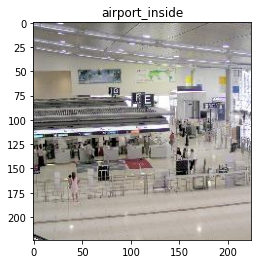

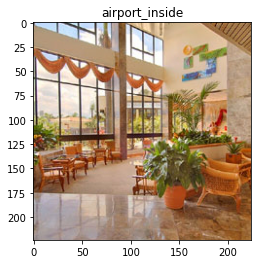

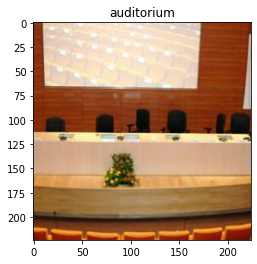

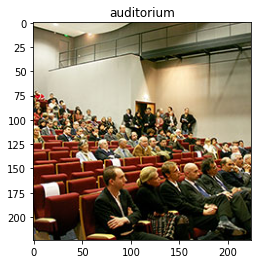

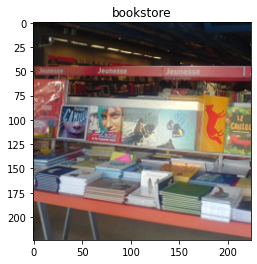

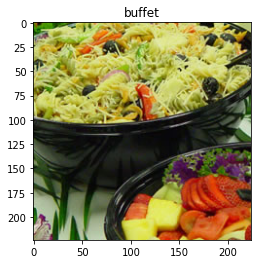

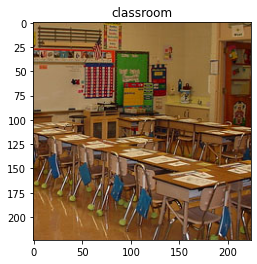

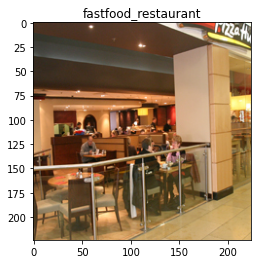

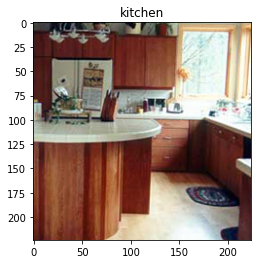

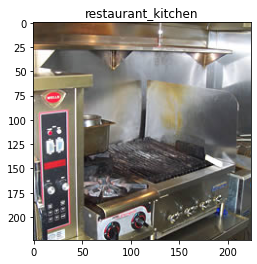

In [14]:
# Visualize 10 images in the dataset with their labels
%matplotlib inline

import matplotlib.pyplot as plt

sample_idxs = [1, 3, 213, 224, 567, 779, 1052, 2000, 3000, 4444]
for sample_idx in sample_idxs:
    data, label = train_dataset[sample_idx]
    plt.imshow(data.permute(1, 2, 0))
    plt.title(train_dataset.classes[label])
    plt.show()

We can see that these images are now having the same size due to our transformation above, and some examples can be really hard to classify - like the airport inside class!

## 1.1.4 Class frequency distributions (5 points)
Create a frequency distribution of the classes in the training dataset. You should create a dictionary with the number of images belonging to each of the category. The key for the dictionary should be the name of the scene and the value should be the frequency in the train dataset. (Hint: The labels are integer indices for each class, and you can get the complete list of label names with `train_dataset.classes`, take a look at the code in Section 1.1.3 if you are lost!)

In [15]:
# TODO: Create the scene frequency distribution
def create_frequency_dict(train_dataset):
    scene_frequency_dict = {}
    for i in range(len(train_dataset)):
        data, label = train_dataset[i]
        scene = train_dataset.classes[label]
        if scene not in scene_frequency_dict.keys():
          scene_frequency_dict[scene] = 0
        else:
          scene_frequency_dict[scene] += 1  
    return scene_frequency_dict


scene_frequency_dict = create_frequency_dict(train_dataset)
print(scene_frequency_dict)

{'airport_inside': 79, 'artstudio': 79, 'auditorium': 81, 'bakery': 80, 'bar': 81, 'bathroom': 81, 'bedroom': 78, 'bookstore': 79, 'bowling': 79, 'buffet': 78, 'casino': 79, 'children_room': 81, 'church_inside': 80, 'classroom': 81, 'cloister': 79, 'closet': 80, 'clothingstore': 81, 'computerroom': 79, 'concert_hall': 79, 'corridor': 78, 'deli': 80, 'dentaloffice': 78, 'dining_room': 81, 'elevator': 78, 'fastfood_restaurant': 79, 'florist': 80, 'gameroom': 79, 'garage': 80, 'greenhouse': 79, 'grocerystore': 78, 'gym': 79, 'hairsalon': 78, 'hospitalroom': 79, 'inside_bus': 76, 'inside_subway': 78, 'jewelleryshop': 77, 'kindergarden': 78, 'kitchen': 78, 'laboratorywet': 77, 'laundromat': 76, 'library': 78, 'livingroom': 79, 'lobby': 79, 'locker_room': 78, 'mall': 79, 'meeting_room': 77, 'movietheater': 79, 'museum': 76, 'nursery': 78, 'office': 78, 'operating_room': 80, 'pantry': 79, 'poolinside': 78, 'prisoncell': 79, 'restaurant': 79, 'restaurant_kitchen': 76, 'shoeshop': 79, 'stairsca

In [16]:
# Grader Cell - DO NOT MODIFY: 5 Points
grader.grade('check_freq_dists', scene_frequency_dict)

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Does the class distribution look uniform? If yes, we don't need to address class imbalance, if no, what should we do?

## 1.1.5 Create Dataloader objects (5 points)


[Data loaders](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) create data batches on the images. In this section, you should create train and test data loaders. You will also need to pass in the batch size and whether or not you want to shuffle the data. 

Set `shuffle = True` for the train and `False` for the test set. 
* Use a batch size of 32 for the training loader.
* Use a batch size of 1 for the test set.


In [17]:
from torch.utils.data import DataLoader

# TODO: Define the transformation and the train and test loaders
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=1,shuffle=False)

In [18]:
# Grader Cell - DO NOT MODIFY: 5 Points
answer = None
for data, label in train_loader:
    answer = data.numpy().shape, label.numpy().shape
    break

answer2 = None
for data, label in test_loader:
    answer2 = data.numpy(), label.numpy()
    break

grader.grade('check_loaders', (answer, answer2))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# Section 2: Let's build classifiers!

We have the data we need to train a scene classifier. We will start simple with a logistic regression classifier as a baseline for our performance before we move onto more complex neural networks. 

## 2.1.1 Logical Logistic Regression - Baseline (25 points)

 Let's first try solving this problem with a Logistic Regression classifier solving the multiclass classification problem.

We will define a logistic regression model in PyTorch and train it on our training set and evaluate the performance on the test set.


### Model Definition

We will start by first defining the loss function for our model.

This is a multi-class classification problem, so we will use the *categorical cross-entropy* loss function. It is defined as:

$$L(y,\hat y)=-\sum_{j=0}^M\sum_{i=0}^{N}(y_{ij} log(\hat y_{ij}))$$

Luckily, we don't have to write it ourselves, we will use the implementation within PyTorch.

Let's first define our criterion i.e. the loss function we want to optimize for.

Read more about PyTorch Cross Entropy loss function [here](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [19]:
# TODO: Define a PyTorch Cross Entropy Loss object, name it 'criterion', 
# this loss function does a log-softmax first to get the probabilities
# and then computes the Negative Log Likelihood loss
criterion = torch.nn.CrossEntropyLoss() 

In [20]:
# Grader Cell - DO NOT MODIFY: 5 Points
grader.grade('check_criterion', str(criterion))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


We now define our first model structure in PyTorch. 

Our first model is a logistic regression model with the number of outputs equal to the number of classes in the model. Define and initialize a logistic regression model, you can either define a class that extends the `nn.module` (as shown in [link](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)) or make use of the `nn.Sequential` container ([link](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)).

*Note* that the `CrossEntropyLoss` function in PyTorch already includes the step to take softmax of outputs.

In [21]:
for data, labels in train_loader:
    print("The shape of inputs is:", data.shape)
    print("The shape of labels is:", labels.shape)
    break

print("Number of classes:", len(train_dataset.classes))

The shape of inputs is: torch.Size([32, 3, 224, 224])
The shape of labels is: torch.Size([32])
Number of classes: 67


In [69]:
# TODO: Define and initialize a logistic regression model, save it in a variable called `lr_model`
import torch.nn.functional as F

class LinearRegressionModel(nn.Module):
  def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

  def forward(self, x):
      outputs = self.linear(x)
      return outputs
lr_model = LinearRegressionModel( 3*224*224, 67)

Let's take a look at our model summary!
Check out [torchsummary](https://github.com/sksq96/pytorch-summary) for how to pretty print the model layers.

In [70]:
lr_input_dim =  3*224*224 # TODO: use your input dimension for the Logistic Regression model here
summary(lr_model.to(device), (1, lr_input_dim))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 67]      10,085,443
Total params: 10,085,443
Trainable params: 10,085,443
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 0.00
Params size (MB): 38.47
Estimated Total Size (MB): 39.05
----------------------------------------------------------------


In [71]:
# Grader Cell - DO NOT MODIFY: 5 Points
grader.grade('check_log_reg_model', [str(child) for child in lr_model.children()])

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Next, we define an optimizer object - we will use a stochastic gradient descent optimizer to optimize for our criterion and update our weights. 
We need several parameters while defining a pytorch optimizer. 

1.   Trainable parameters in the model - model.parameters() gives you all these parameters
2.   Optimizer params - Check out the required parameters for each typr of optimizer in their documentation. For 'sgd' and 'Adam', a minimum requirement is to specify the learning rate parameter.

The learning rate is a hyperparameter that you should tune for. You can start with a small learning rate like 1e-3 or 1e-4.

For this task, you might have better luck with the Adam adaptive optimizer than with stochastic gradient descent aka SGD.

Read more about the optimizer objects [here](https://pytorch.org/docs/stable/optim.html).




In [72]:
# TODO: define the optimizer object for Logistic Regression
import torch.optim as optim 
lr_optimizer = optim.Adam(lr_model.parameters(),lr=1e-4)

### Train Model

Next, we need to iterate through our training data multiple times to optimize our weights. Each of the iterations is called an epoch. 

We will write a training loop now. Here is the pseudocode for the training loop: 

1.   Repeat the following for a number of epochs
2.   Iterate through the mini batches in the training dataloader
3.   Each minibatch object will be a tuple `(data, labels)`
4.   Each minibatch has a number of images and a number of labels (batch size number of images and labels in each minibatch). Thus each data object will be of the shape `(BATCH_SIZE, 224, 224, 3)`. The 3 corresponds to the number of channels - RGB and the labels tensor would be of size `(BATCH_SIZE)`
5.   Since our model requires linear inputs and not multiple channels, flatten the image in the batch. The `view` ([link](https://pytorch.org/docs/stable/tensors.html?highlight=view#torch.Tensor.view)) function or `flatten` ([link1](https://pytorch.org/docs/stable/generated/torch.flatten.html))([link2](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html?highlight=flatten#torch.nn.Flatten)) function will help you to do this.
6.   Use `to(device)` to send the data and label to the GPU to get faster training!
7.   Compute the model outputs for the flattened data using the model object defined above.
8.   Compute the loss function with criterion we previously defined.
10.  Backpropogate through the computed loss value. This would compute the gradients for each of the model parameters.
11.  Use an optimizer to perform an optimizer step - this updates the weights based on the computed gradients wrt the loss function.
1.   Compute the training accuracy for the current epoch.
12.  To see how your accuracy improves and the loss decreases, after each epoch print out the accuracy and the loss for that epoch. 


You should also plot your training accuracies and training loss function vs epochs. The plot is worth 5 points!


Train your logistic regression model for 10 epochs.

In [73]:
def train_model(model, optimizer, criterion, epochs=10):
    for child in model.children():
      if hasattr(child, 'reset_parameters'):
        child.reset_parameters()
    model.train()
    model.to(device)
    
    # TODO: Implement your training loop as specified in the description
    for epoch in range(epochs):
      train_loss = 0
      correct = 0
      for batch, (data, label) in enumerate(train_loader): 
        data = data.to(device).view(data.shape[0],-1) 
        label = label.to(device)
        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        correct += (label == output.argmax(axis=1)).sum().item()

      accuracy = correct/len(train_dataset)
      loss = train_loss/len(train_loader)
      loss_list.append(loss)
      accuracy_list.append(accuracy)

      print(epoch+1, 'loss:', loss)
      print(epoch+1, 'accuracy:', accuracy)

    final_training_accuracy = accuracy    # TODO: Set this to final training accuracy
    final_training_loss = loss    # TODO: Set this to final testing accuracy
    return final_training_loss, final_training_accuracy

    

In [74]:
loss_list = []
accuracy_list = []
lr_training_loss, lr_training_accuracy = train_model(lr_model, lr_optimizer, criterion)

print("Logistic Regression - the training loss is ", str(lr_training_loss))
print("Logistic Regression - the training accuracy is ", str(lr_training_accuracy))

1 loss: 6.880027505452047
1 accuracy: 0.03052434456928839
2 loss: 5.5444176411200425
2 accuracy: 0.09250936329588015
3 loss: 5.065118675460359
3 accuracy: 0.14213483146067415
4 loss: 4.244553364679485
4 accuracy: 0.2245318352059925
5 loss: 3.930922840883632
5 accuracy: 0.27565543071161047
6 loss: 3.5049315805206755
6 accuracy: 0.35093632958801496
7 loss: 2.9605193073878033
7 accuracy: 0.4202247191011236
8 loss: 2.708006626831557
8 accuracy: 0.4651685393258427
9 loss: 2.2807783159667148
9 accuracy: 0.5350187265917603
10 loss: 2.0331349058779415
10 accuracy: 0.5895131086142322
Logistic Regression - the training loss is  2.0331349058779415
Logistic Regression - the training accuracy is  0.5895131086142322


In [75]:
# Grader Cell - DO NOT MODIFY: 5 Points
grader.grade('check_lr_train', (lr_training_accuracy, lr_training_loss))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Text(0.5, 1.0, 'accuracy')

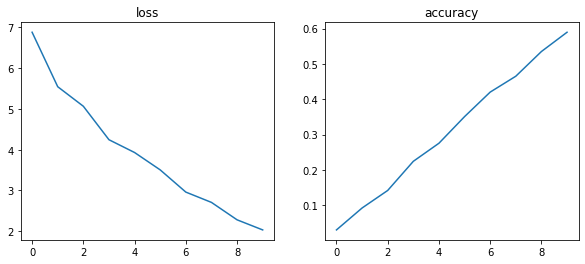

In [76]:
from matplotlib import pyplot as plt
# TODO: Plot a graph of your training accuracies and training loss vs epochs! (5 Points)
# You can make use of the `loss_list` and `accuracy_list` variables defined above.
# Remember to include a legend for the curves denoting whether it is loss or accuracy.
# Please make sure the plot is present when your submit this notebook, 
# otherwise no points would be given for this part!

fig = plt.figure()
fig.set_size_inches(10, 4)
sub1 = fig.add_subplot(1,2,1)
sub1.plot(loss_list)
sub1.set_title('loss')
sub2 = fig.add_subplot(1,2,2)
sub2.plot(accuracy_list)
sub2.set_title('accuracy')


Is your model learning? Is the loss decreasing? Is it able to classifiy better after training?


### Evaluate Model

Evaluate the model performance on the test set. Compute the cross entropy loss and accuracy on the test set.

Note:  Please don't report false numbers for the accuracy as we will be reviewing these manually and if if there is a manipulation with the accuracy computation, you will get a 0 for the entire section.


In [77]:
def test_model(model, criterion):
    model.eval()

    # TODO: Implement your testing loop with the `test_loader` data
    test_loss = 0
    correct = 0
    for batch, (data, label) in enumerate(test_loader):
        data = data.to(device).view(1,-1) 
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
        test_loss += loss.item()
        if output.argmax(axis=1)[0].item() == label[0].item():
            correct += 1

    testing_loss = test_loss/len(test_loader)         # TODO: Set this to your testing loss
    testing_accuracy = correct/len(test_dataset)     # TODO: Set this to your testing accuracy
    return  testing_loss, testing_accuracy

In [78]:
lr_testing_loss, lr_testing_accuracy = test_model(lr_model, criterion)

print("Logistic Regression - the testing loss is ", str(lr_testing_loss))
print("Logistic Regression - the testing accuracy is ", str(lr_testing_accuracy))

Logistic Regression - the testing loss is  6.2300849047964215
Logistic Regression - the testing accuracy is  0.05105105105105105


In [79]:
# Grader Cell - DO NOT MODIFY: 5 Points
grader.grade('check_lr_test', (lr_testing_accuracy, lr_testing_loss))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Does the logistic regression fit well to the data? Think about whether this is underfitting or overfitting? Think about if we need more representational power or we need more regularization to make it better?

## 2.1.2 Feedforward Neural Networks (25 points)

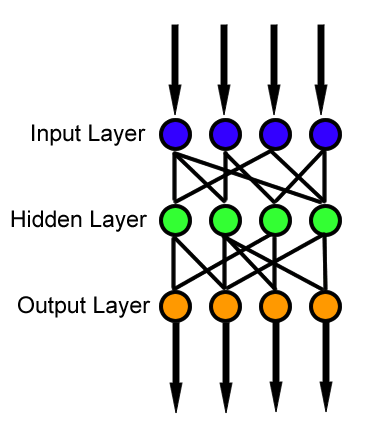

Since logistic regression isn't that great at fitting our classification problem, we need more representation power. We will now define a feedforward neural network.


Define a feedforward neural network with at least 2 hidden fully-connected layers (not including the input and output layer). Note that the last layer must have the number of classes as the output size. You will also need to initialize the network, create a new optimizer
 object with the parameters of the feedforward network. Use a ReLU activation function for the hidden layers. 


In [80]:
# TODO: Define and initialize an FNN model, save it in a variable called `fnn_model`
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3*224*224, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128,67)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x
fnn_model = Net()

Print the model summary for the fully connected network.

In [81]:
fnn_input_dim = 3*224*224           # TODO: use your input dimension for the FNN model here
summary(fnn_model.to(device), (1, fnn_input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 512]      77,070,848
              ReLU-2               [-1, 1, 512]               0
            Linear-3               [-1, 1, 256]         131,328
              ReLU-4               [-1, 1, 256]               0
            Linear-5               [-1, 1, 128]          32,896
              ReLU-6               [-1, 1, 128]               0
            Linear-7                [-1, 1, 67]           8,643
Total params: 77,243,715
Trainable params: 77,243,715
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 0.01
Params size (MB): 294.66
Estimated Total Size (MB): 295.25
----------------------------------------------------------------


In [82]:
# Grader Cell - DO NOT MODIFY: 8 Points
grader.grade('check_fnn_model', [str(child) for child in fnn_model.children()])

Correct! You earned 8/8 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Now train this network using the `train_model` function defined above. 

Create plots for the training accuracy and training loss vs the number of epochs.


In [83]:
# Train the FNN model on the training set using the `train_model` function
loss_list = []
accuracy_list = []
fnn_epochs = 15                # TODO: set the number of epochs
fnn_optimizer = torch.optim.Adam(fnn_model.parameters(), lr= 1e-4)             # TODO: initialize the optimizer
fnn_training_loss, fnn_training_accuracy = train_model(fnn_model, fnn_optimizer, criterion, fnn_epochs)

print("Feedforward Neural Network - the training loss is ", str(fnn_training_loss))
print("Feedforward Neural Network - the training accuracy is ", str(fnn_training_accuracy))

1 loss: 4.241849059830169
1 accuracy: 0.015355805243445693
2 loss: 4.185052180718519
2 accuracy: 0.020973782771535582
3 loss: 4.134802582735073
3 accuracy: 0.03689138576779026
4 loss: 4.077780136805095
4 accuracy: 0.043820224719101124
5 loss: 4.023535552852882
5 accuracy: 0.052059925093632956
6 loss: 3.983718829240628
6 accuracy: 0.05767790262172284
7 loss: 3.9268951430292187
7 accuracy: 0.07078651685393259
8 loss: 3.892608344197987
8 accuracy: 0.08146067415730338
9 loss: 3.8513395357988554
9 accuracy: 0.08389513108614233
10 loss: 3.799869220413848
10 accuracy: 0.09138576779026217
11 loss: 3.764609512454735
11 accuracy: 0.10074906367041199
12 loss: 3.7147764645650714
12 accuracy: 0.10898876404494381
13 loss: 3.665585245200974
13 accuracy: 0.11741573033707865
14 loss: 3.6159885757697556
14 accuracy: 0.12471910112359551
15 loss: 3.56303073831661
15 accuracy: 0.13782771535580524
Feedforward Neural Network - the training loss is  3.56303073831661
Feedforward Neural Network - the training a

In [84]:
# Grader Cell - DO NOT MODIFY: 7 Points
grader.grade('check_fnn_train', (fnn_training_accuracy, fnn_training_loss))

Correct! You earned 7/7 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Text(0.5, 1.0, 'accuracy')

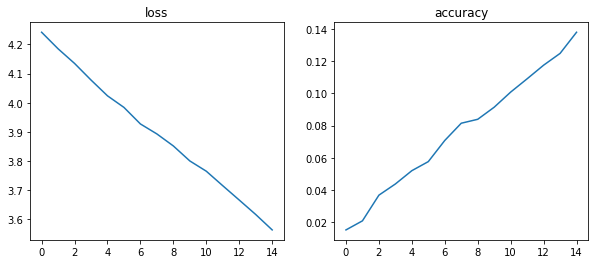

In [85]:
from matplotlib import pyplot as plt
# TODO: Plot a graph of your training accuracies and training loss vs epochs! (5 Points)
# You can make use of the `loss_list` and `accuracy_list` variables defined above.
# Remember to include a legend for the curves denoting whether it is loss or accuracy.
# Please make sure the plot is present when your submit this notebook, 
# otherwise no points would be given for this part!
fig = plt.figure()
fig.set_size_inches(10, 4)
sub1 = fig.add_subplot(1,2,1)
sub1.plot(loss_list)
sub1.set_title('loss')
sub2 = fig.add_subplot(1,2,2)
sub2.plot(accuracy_list)
sub2.set_title('accuracy')

Once again, evaluate the model performance on the test set. Compute the cross entropy loss and accuracy on the test set

In [86]:
# Compute performance on the test set using the test_model function created before
fnn_testing_loss, fnn_testing_accuracy = test_model(fnn_model, criterion)

print("Feedforward Neural Network - the testing loss is ", str(fnn_testing_loss))
print("Feedforward Neural Network - the testing accuracy is ", str(fnn_testing_accuracy))

Feedforward Neural Network - the testing loss is  4.014710141150085
Feedforward Neural Network - the testing accuracy is  0.06381381381381382


In [87]:
# Grader Cell - DO NOT MODIFY: 5 Points
grader.grade('check_fnn_test', (fnn_testing_accuracy, fnn_testing_loss))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Does the feedforward network do better than logistic regression? Play around with the network architecture and number of epochs to see how it affects the performance on both the train and test data.

## 2.1.3 Convolutional Neural Networks (30 points)
**So, what are CNNs?**

Convolutional Neural Networks are very similar to Feedforward Neural Networks from the previous section: they are made up of neurons that have learnable weights and biases. Each neuron receives some inputs, performs a dot product and optionally follows it with a non-linearity. The whole network still expresses a single differentiable score function: from the raw image pixels on one end to class scores at the other. 

So what changes? ConvNet architectures make the explicit assumption that the inputs are images, which allows us to encode certain properties into the architecture. These then make the forward function more efficient to implement and vastly reduce the amount of parameters in the network.

If you wanna know more about how CNNs function and see some cool visualizations, we would highly recommend [this](http://cs231n.github.io/convolutional-networks/) page


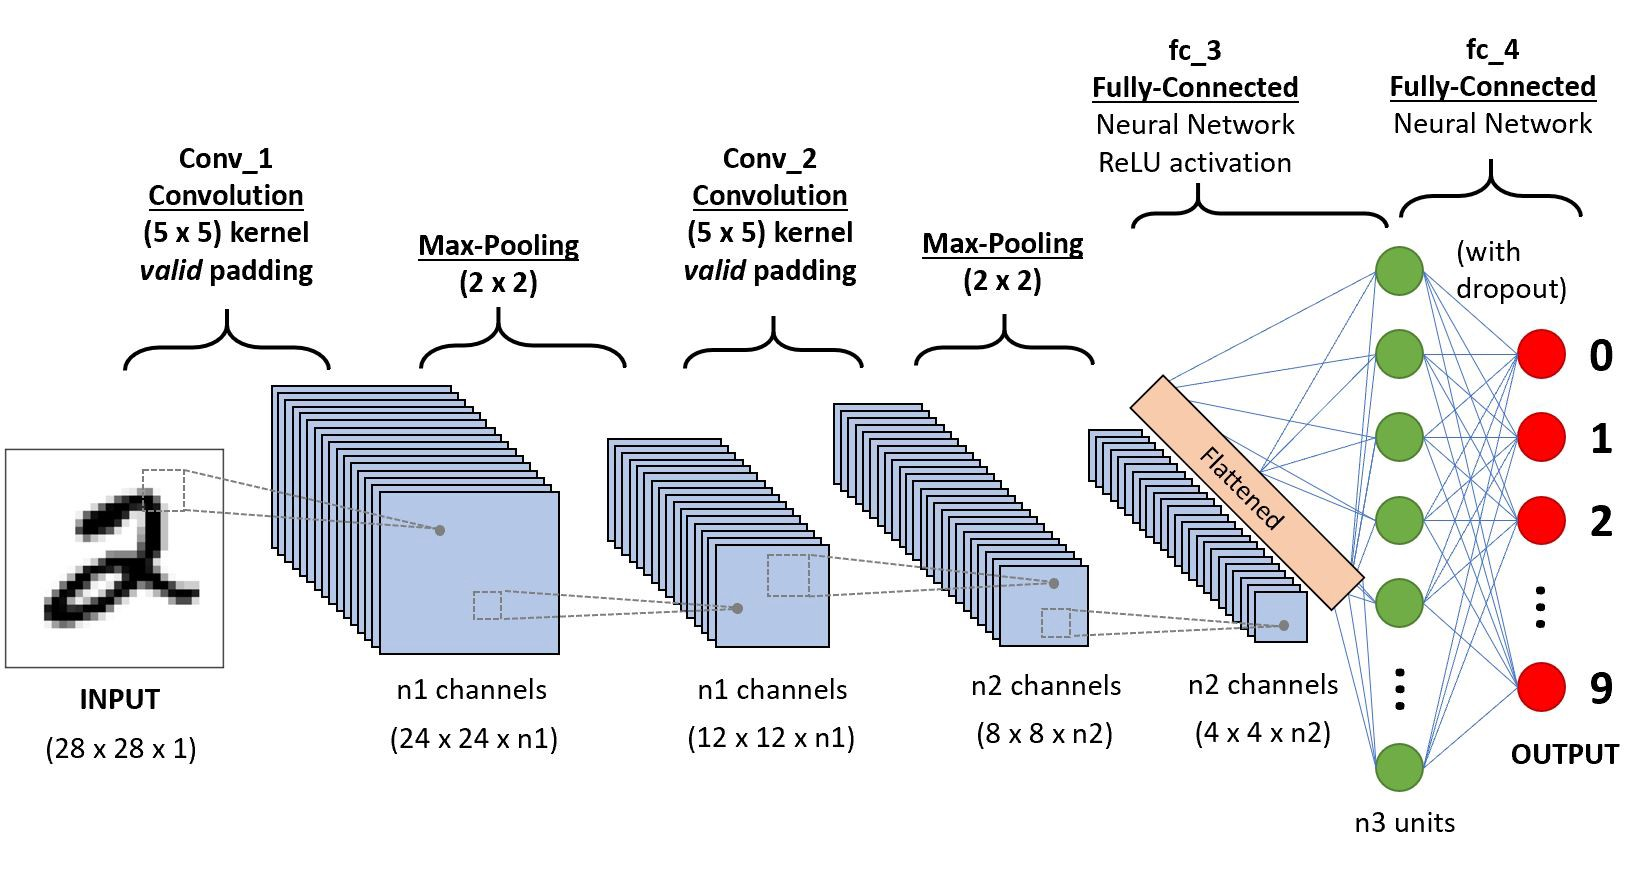


We will define the architecture for the CNN we will be using. The components of CNNs are: 


*   Convolutional Layers
*   Pooling Layers
*   Linear Layers
*   Activation Functions

Define a CNN model in PyTorch: start with a convolutional layer followed by an activation function and a max pool, for one or more layers; then flatten the output from the convolutional layers and pass it through one or more fully connected or 'dense' layers and activation functions after all but the last layer. Note that the output shape from the last layer must be the same as the number of classes.

You can find some examples of how to construct a CNN model [here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

In [88]:
# TODO: Define and initialize a CNN model, save it in a variable called `cnn_model`

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 67)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

cnn_model = CNN()

Let's take a look at the structure of the defined CNN model.

In [89]:
summary(cnn_model.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 220, 220]             456
         MaxPool2d-2          [-1, 6, 110, 110]               0
            Conv2d-3         [-1, 16, 106, 106]           2,416
         MaxPool2d-4           [-1, 16, 53, 53]               0
            Linear-5                  [-1, 120]       5,393,400
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 67]           5,695
Total params: 5,412,131
Trainable params: 5,412,131
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 4.49
Params size (MB): 20.65
Estimated Total Size (MB): 25.71
----------------------------------------------------------------


In [90]:
# Grader Cell - DO NOT MODIFY: 10 Points
grader.grade('check_cnn_model', [str(child) for child in cnn_model.children()])

Correct! You earned 10/10 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Write another function to train a convolutional neural network on the train data given the network, trainer and criterion. Train the CNN for 10-25 epochs. 

Plot the training loss and accuracy curves.

Note that there will be a slight difference from training a feedforward network, because here you will use the image information in separate chanels as the input rather than a single flattened input.

Note also that you may have to experiment with the kernel size and stride of the layers, until you get satisfactory performance. To give a hint of what's possible, our classifier achieve an accuracy score of 0.99 on this part (i.e., with the training dataset).

In [101]:
# Define a training function which trains the passed model for the given number of epochs using the provided optimizer and criterion
# The function should return the final training loss and the final training accuracy
def train_cnn(model, optimizer, criterion, epochs=10):
    for child in model.children():
      if hasattr(child, 'reset_parameters'):
        child.reset_parameters()
    model.to(device)
    model.train()

    # TODO: Implement your training loop as specified in the description
    for epoch in range(epochs):
      train_loss = 0
      correct = 0
      for batch, (data, label) in enumerate(train_loader):
        
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (label == output.argmax(axis=1)).sum().item()

      accuracy = correct/len(train_dataset)
      loss = train_loss/len(train_loader)
      loss_list.append(loss)
      accuracy_list.append(accuracy)
  
      print(epoch+1, 'loss:', loss)
      print(epoch+1, 'accuracy:', accuracy) 

    final_training_accuracy = accuracy     # TODO: Set this to final training accuracy
    final_training_loss = loss        # TODO: Set this to final testing accuracy
    return final_training_loss, final_training_accuracy

In [102]:
# Train the CNN model on the training set using the `train_cnn` function
loss_list = []
accuracy_list = []
cnn_epochs =  10                    # TODO: set the number of epochs
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-3)                   # TODO: initialize the optimizer
cnn_training_loss, cnn_training_accuracy = train_cnn(cnn_model, cnn_optimizer, criterion, cnn_epochs)

print("Convolutional Neural Network - the training loss is ", str(cnn_training_loss))
print("Convolutional Neural Network - the training accuracy is ", str(cnn_training_accuracy))

1 loss: 4.194208036639734
1 accuracy: 0.017977528089887642
2 loss: 4.073538194873376
2 accuracy: 0.03707865168539326
3 loss: 3.8465079233318034
3 accuracy: 0.07415730337078652
4 loss: 3.52938419616151
4 accuracy: 0.12172284644194757
5 loss: 2.9276926474656886
5 accuracy: 0.25374531835205993
6 loss: 1.9226431860895214
6 accuracy: 0.48164794007490636
7 loss: 1.0078055207243937
7 accuracy: 0.7303370786516854
8 loss: 0.4453776440399136
8 accuracy: 0.8913857677902621
9 loss: 0.2107095784859029
9 accuracy: 0.9516853932584269
10 loss: 0.12939911171749324
10 accuracy: 0.9728464419475655
Convolutional Neural Network - the training loss is  0.12939911171749324
Convolutional Neural Network - the training accuracy is  0.9728464419475655


In [103]:
# Grader Cell - DO NOT MODIFY: 8 Points
grader.grade('check_cnn_train', (cnn_training_accuracy, cnn_training_loss))

Correct! You earned 8/8 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Text(0.5, 1.0, 'accuracy')

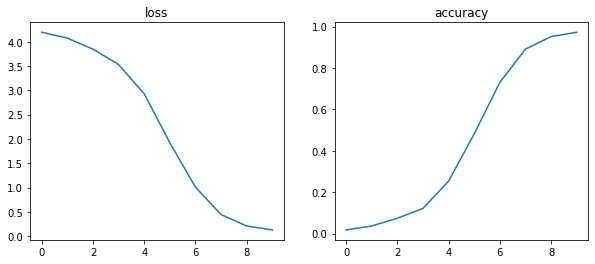

In [104]:
from matplotlib import pyplot as plt
# TODO: Plot a graph of your training accuracies and training loss vs epochs! (5 Points)
# You can make use of the `loss_list` and `accuracy_list` variables defined above.
# Remember to include a legend for the curves denoting whether it is loss or accuracy.
# Please make sure the plot is present when your submit this notebook, 
# otherwise no points would be given for this part!
fig = plt.figure()
fig.set_size_inches(10, 4)
sub1 = fig.add_subplot(1,2,1)
sub1.plot(loss_list)
sub1.set_title('loss')
sub2 = fig.add_subplot(1,2,2)
sub2.plot(accuracy_list)
sub2.set_title('accuracy')

Once again, evaluate the model performance on the test set. Compute the cross entropy loss and accuracy on the test set.

In [113]:
# TODO: Compute performance on the test set
# you may need to write a new function similar to `test_model` but without the flattening aspect
def test_cnn_model(model, criterion):
    model.eval()

    # TODO: Implement your testing loop with the `test_loader` data
    test_loss = 0
    correct = 0
    for batch, (data, label) in enumerate(test_loader):
        data = data.to(device) 
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
        test_loss += loss.item()
        if output.argmax(axis=1)[0].item() == label[0].item():
            correct += 1

    testing_loss = test_loss/600       # TODO: Set this to your testing loss
    testing_accuracy = correct/600     # TODO: Set this to your testing accuracy
    return  testing_loss, testing_accuracy



cnn_testing_loss, cnn_testing_accuracy = test_cnn_model(cnn_model, criterion)

print("Convolutional Neural Network - the testing loss is ", str(cnn_testing_loss))
print("Convolutional Neural Network - the testing accuracy is ", str(cnn_testing_accuracy))

Convolutional Neural Network - the testing loss is  21.57854750361888
Convolutional Neural Network - the testing accuracy is  0.17


In [114]:
# Grader Cell - DO NOT MODIFY: 7 Points
grader.grade('check_cnn_test', (cnn_testing_accuracy, cnn_testing_loss))

Correct! You earned 7/7 points. You are a star!

Your submission has been successfully recorded in the gradebook.


How does the CNN perform? Does it out perform feedforward network?

Print out the number of learned parameters for the CNN and for the FFN. Does the CNN have more parameters? Think about how this links to performance and how CNN is so powerful?

# HW Submission

**Double check that you have the correct PennID (all numbers) in the autograder**. 

Go to the 'File' tab at the top left, and click 'Download .ipynb'. Also 'Download .py'. Submit both files to GradeScope. Make sure the .py file is named 'hw5.py'. 

You must submit your notebook to GradeScope to receive credit.

Also remember to make sure all the plots are correctly shown in the saved ipynb notebook!

# YAAAAAAY

This is the end of this homework - and all the homeworks for this course! 

Congratulations on your great work throughout the semester!

![](https://media.giphy.com/media/kBZBlLVlfECvOQAVno/giphy.gif)

Feel free to fill out [this form](https://docs.google.com/forms/d/e/1FAIpQLSchVNlVVOZ4AnVea8NmBwaDHAadBVWET7ptcOMWrU-SUH9-xg/viewform?usp=sf_link) with any feedback for this and prior homeworks.